In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
from google.colab import files
uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [53]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
gender_submission_df = pd.read_csv('gender_submission.csv')


In [54]:
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [56]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [57]:
train_df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [58]:
test_df.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [59]:
gender_submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [60]:
drop_cols = ['PassengerId','Ticket','Cabin']
train_df.drop(drop_cols,axis=1,inplace=True)
test_df.drop(drop_cols,axis=1,inplace=True)

In [61]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())

In [62]:
# Only extract titles if 'Name' exists AND 'Title' doesn't already exist
if 'Name' in train_df.columns and 'Title' not in train_df.columns:
    train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Only create family features if they don't exist
if 'FamilySize' not in train_df.columns:
    train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
    train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)
    test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
    test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)

# Drop columns only if they exist
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df.drop([col for col in drop_cols if col in train_df.columns], axis=1, inplace=True)
test_df.drop([col for col in drop_cols if col in test_df.columns], axis=1, inplace=True)

In [63]:
print("Columns in train_df:", train_df.columns.tolist())
print("Columns in test_df:", test_df.columns.tolist())

Columns in train_df: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']
Columns in test_df: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']


In [67]:
# 1. First make sure you've done all feature engineering
# (Title extraction, family size, etc.)

# 2. Handle missing values
# (Your existing code for Age, Fare, Embarked)

# 3. Convert all categorical variables
categorical_cols = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']  # Add any others
categorical_cols = [col for col in categorical_cols if col in train_df.columns]

train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

# 4. Align columns
missing_cols = set(train_df.columns) - set(test_df.columns) - {'Survived'}
for col in missing_cols:
    test_df[col] = 0

test_df = test_df[train_df.columns.drop('Survived', errors='ignore')]

# 5. Train-test split
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=101,
    stratify=y
)

# 6. Train model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)
model.fit(X_train, y_train)

# 7. Evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Training Metrics:")
print(classification_report(y_train, y_train_pred))
print("\nTest Metrics:")
print(classification_report(y_test, y_test_pred))

Training Metrics:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       384
           1       0.83      0.79      0.81       239

    accuracy                           0.86       623
   macro avg       0.85      0.85      0.85       623
weighted avg       0.86      0.86      0.86       623


Test Metrics:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       165
           1       0.80      0.65      0.72       103

    accuracy                           0.80       268
   macro avg       0.80      0.77      0.78       268
weighted avg       0.80      0.80      0.80       268



In [68]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Enhanced Feature Engineering
def create_features(df):
    # Existing features
    if 'Name' in df.columns:
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        # Normalize titles
        title_map = {
            'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
            'Col': 'Rare', 'Major': 'Rare', 'Dr': 'Rare',
            'Rev': 'Rare', 'Capt': 'Rare', 'Jonkheer': 'Rare',
            'Don': 'Rare', 'Sir': 'Rare', 'Lady': 'Rare',
            'Countess': 'Rare', 'Dona': 'Rare'
        }
        df['Title'] = df['Title'].replace(title_map)

    # Family features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # New features
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100],
                          labels=['Child', 'Teen', 'Adult', 'MidAge', 'Senior'])
    df['FareGroup'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Mid', 'High', 'VIP'])
    df['SocioEconomic'] = df['Pclass'].astype(str) + '_' + df['FareGroup'].astype(str)

    return df

train_df = create_features(train_df)
test_df = create_features(test_df)

# 2. Handle Missing Values
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

if 'Embarked' in train_df.columns:
    train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

# 3. Encode Categorical Variables
categorical_cols = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup', 'SocioEconomic']
categorical_cols = [col for col in categorical_cols if col in train_df.columns]

train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

# 4. Align Columns Between Train and Test
missing_cols = set(train_df.columns) - set(test_df.columns) - {'Survived'}
for col in missing_cols:
    test_df[col] = 0

test_df = test_df[train_df.columns.drop('Survived', errors='ignore')]

# 5. Train-Test Split with Stratification
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # Slightly smaller test size for more training data
    random_state=101,
    stratify=y
)

# 6. Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

# 7. Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training predictions
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]

    # Test predictions
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    print("\nTraining Metrics:")
    print(classification_report(y_train, y_train_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_train, y_train_pred))

    print("\nTest Metrics:")
    print(classification_report(y_test, y_test_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))

    return y_test_prob

y_test_prob = evaluate_model(best_model, X_train, y_train, X_test, y_test)

# 8. Feature Importance Analysis
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))

# 9. Prepare Test Set Predictions (for submission if needed)
test_predictions = best_model.predict(test_df)
test_probabilities = best_model.predict_proba(test_df)[:, 1]  # Survival probabilities

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters found:
{'class_weight': None, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Training Metrics:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       439
           1       0.83      0.77      0.80       273

    accuracy                           0.85       712
   macro avg       0.85      0.83      0.84       712
weighted avg       0.85      0.85      0.85       712

Confusion Matrix:
[[396  43]
 [ 64 209]]

Test Metrics:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       110
           1       0.84      0.62      0.72        69

    accuracy                           0.81       179
   macro avg       0.82      0.78      0.79       179
weighted avg       0.81      0.81      0.80       179

Confusion Matrix:
[[102   8]
 [ 26  43]]

Top 10 Most

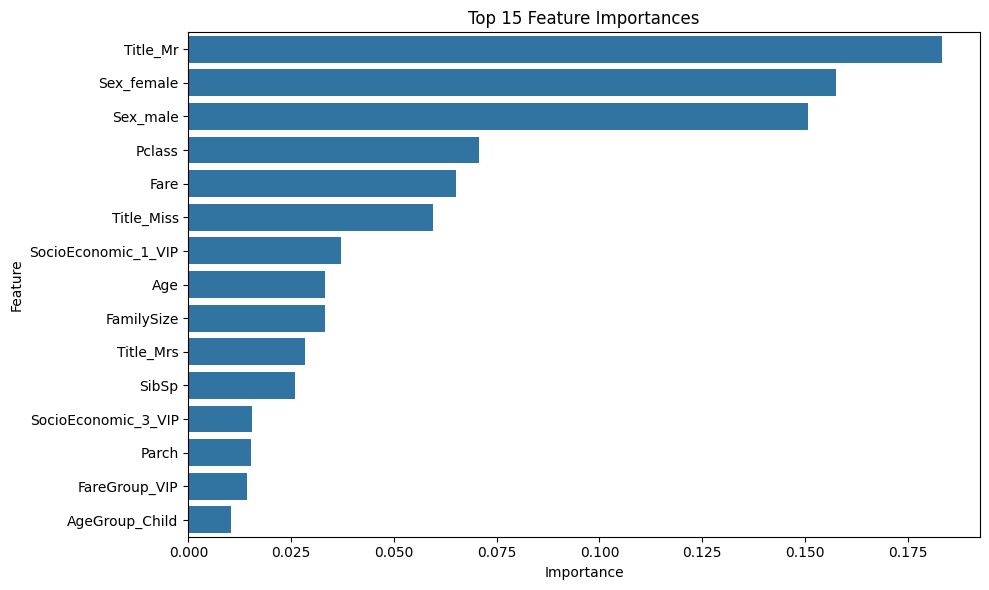

In [71]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()


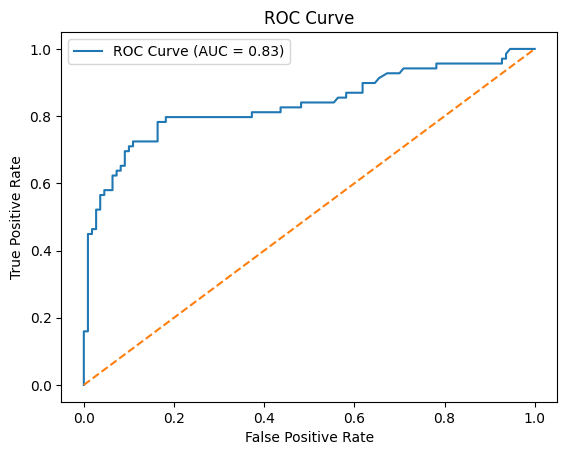

In [72]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
